In [1]:
%config Completer.use_jedi = False
import math
import pandas as pd 
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.decomposition import PCA
import holidays 
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.express as px 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

class Feature_Extraction():
    
    def GET_deleted_columns(self,data,variables_to_remove):
        """
        This functions is used to maintain the list of variables which are highly collinear with the 
        output variable and must be removed to maintain a good list of training data
        """
        for variable in variables_to_remove:
            try:
                data = data.drop(columns = [variable])
            except KeyError:
                pass
        return data

    def GET_Scaled_data(self,data):
        column_names = data.columns
        scaler = StandardScaler()
        #print(scaler.fit(data))
        scaled_data = scaler.fit_transform(data)
        scaled_data = pd.DataFrame(scaled_data)
        scaled_data.columns = column_names
        return scaled_data, scaler
    
    def GET_data_splits(self,X,Y):
        """
        The objective of this function is to split the data into it's own train/test/validation splits
        X_train, X_test, y_train, y_test
        """
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle = True)
        
        X_train = X_train.reset_index(inplace = False)
        X_train = X_train.drop(columns = ["index"])
        
        X_test = X_test.reset_index(inplace = False)
        X_test = X_test.drop(columns = ["index"])
        
        y_train = y_train.reset_index(inplace = False)
        y_train = y_train.drop(columns = ["index"])
        
        y_test = y_test.reset_index(inplace = False)
        y_test = y_test.drop(columns = ["index"])
        return X_train, X_test, y_train, y_test
    
    def GET_reduce_time_features(self,df,variable_name):
        df[variable_name] = pd.to_datetime(df[variable_name],unit='s')
        list_of_times = []
        for i in range(0,len(df)):
            date = str(df[variable_name][i])
            datem = datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
            extracted_time = [datem.year,datem.month,datem.day,datem.hour]
            list_of_times.append(extracted_time)
        combined = pd.DataFrame(list_of_times)
        combined.columns = [variable_name+"_year",
                           variable_name+"_month",
                           variable_name+"_day",
                           variable_name+"_hour"]
        merged_df = pd.concat([df, combined], axis=1, join='inner')
        merged_df = merged_df.drop(columns = [variable_name])
        return merged_df
    
    def GET_time_features(self,data):
        data = self.SET_day_type(data,"start_time")
        data = self.GET_reduce_time_features(data,"start_time")
        data = self.GET_reduce_time_features(data,"end_time")
        return data 
    
    def SET_day_type(self,data,variable_name):
        # Weekdays = 0 
        # Weekend = 1
        # Holiday = 2
        data["temp"] = pd.to_datetime(data[variable_name],unit='s')
        result = []
        import holidays
        us_holidays = holidays.US()
        for i in range(0,len(data)):
            current_time = data["temp"][i]
            if current_time in us_holidays:
                result.append(2)
            else:
                day_type = current_time.weekday()
                if day_type <= 5:
                    result.append(0)
                if day_type >5:
                    result.append(1)
        data["day_type"] = result
        data = data.drop(columns = ["temp"])
        return data
    
    def GET_X_and_Y(self,data,target_variable):
        X = data[[item for item in data.columns if item != target_variable]]
        Y = data[[target_variable]]
        return X, Y
    
    def GET_BUS_DESIGN(self,data):    
        manufacturer = []
        capacity = []
        missing = 0 
        for i in range(0,len(data)):
            current = data["bus_id"][i]
            #print("fault")
            # 1 - Corresponds to New Flyer -> culver city 
            # 2 - Corresponds to Portera  - > foothill 
            # 3 - Corresponds to Alexander Dennis
            if str(current)[0:1] == "7":
                manufacturer.append(1)
                if current == 7157:
                    capacity.append(350)
                else:
                    # this includes 7156, 7158, 7159
                    capacity.append(440)
            if str(current)[0:1] in "2":
                manufacturer.append(2)
                if current in list(range(2001,2016)):
                    capacity.append(72)
                if current in list(range(2016,2018)):
                    capacity.append(79)
                if current in list(range(2600,2614)):
                    capacity.append(440)
                if current in list(range(2800,2803)):
                    capacity.append(440)

            if str(current)[0:2] == "30":
                manufacturer.append(3)
                if current in [3000,3001]:
                    capacity.append(648)

        if len(capacity) != len(data) or  len(manufacturer) != len(data) :
            print("UNIDENTIFIED BUS_ID ENTERED")

        else:
            data["BATTERY_CAPACITY"] = capacity
            data['MANUFACTURER'] = manufacturer
            data = data.drop(columns = ["bus_id"])
            return data

In [2]:
class CLUSTERING_MODEL(): 
    def __init__(self,num_iterations,num_clusters):
        self.iterations = num_iterations
        self.clusters = num_clusters
        self.data = data.copy()

    def gmm(self):
        from sklearn.mixture import GaussianMixture
        total_predictons = []
        for i in range(0,self.iterations):
            gm = GaussianMixture(n_components=self.clusters , random_state=0).fit_predict(self.data)
            total_predictons.append(pd.DataFrame(gm).T)
        concatenated = pd.concat(total_predictons)
        round_kmeans_predictions = round(concatenated.mean(axis=0))
        self.data["GMM_Prediction"]=round_kmeans_predictions
        self.data['GMM_Prediction']=self.data['GMM_Prediction'].replace(0,-1)

    def agglomerative(self):
        num_iterations = self.iterations/10
        from sklearn.cluster import AgglomerativeClustering
        total_predictons = []
        for i in range(0,num_iterations):
            prediction = AgglomerativeClustering().fit_predict(self.data)
            total_predictons.append(pd.DataFrame(prediction).T)
        concatenated = pd.concat(total_predictons)
        agglomerative_predictions = round(concatenated.mean(axis=0))
        self.data["Agglomerative"]=agglomerative_predictions
        self.data['Agglomerative']=self.data['Agglomerative'].replace(0,-1)
        return data

    def kmeans(self):
        num_iterations = self.iterations
        from sklearn.cluster import KMeans
        total_predictons = []
        for i in range(0,num_iterations):
            kmeans = KMeans(n_clusters=self.clusters, random_state=0).fit(self.data)
            current_kmeans_predictions = kmeans.labels_
            total_predictons.append(pd.DataFrame(current_kmeans_predictions).T)
        concatenated = pd.concat(total_predictons)
        round_kmeans_predictions = round(concatenated.mean(axis=0))
        self.data["K_Means_Prediction"]=round_kmeans_predictions
        self.data['K_Means_Prediction']=self.data['K_Means_Prediction'].replace(0,-1)
        return data

    def isolation_forest(self): 
        from sklearn.ensemble import IsolationForest
        total_predictons = []
        for i in range(0,self.iterations):
            current_prediction = IsolationForest(random_state=0).fit_predict(self.data)
            total_predictons.append(pd.DataFrame(current_prediction).T)
        concatenated = pd.concat(total_predictons)
        round_predictions = round(concatenated.mean(axis=0))
        self.data["Isolation_Forest_Prediction"]=round_predictions
        return data

In [3]:
class DIMENSIONALITY_REDUCTION():
    def __init__(self,No_of_components):
        self.components = No_of_components
        self.data = data.copy()
    
    def GET_pca(self):
        pca = PCA(n_components=self.components)
        pca.fit(data)
        print("PCA explains ",round(sum(pca.explained_variance_ratio_),3),"% of the variance in the data")
        data = pca.fit_transform(self.data)
        data = pd.DataFrame(data)
        if self.components == 2:
            data.columns = ["PCA1","PCA2"]
        if self.components == 3:
            data.columns = ["PCA1","PCA2","PCA3"]
        return data
    
    def GET_tsne(self,perplexity=30):
        from sklearn.manifold import TSNE
        n_components=2 
        data =  TSNE(n_components=self.components, 
                     learning_rate="auto",
                     init='random', 
                     perplexity=perplexity).fit_transform(self.data)
        tsne_df = pd.DataFrame(data)
        tsne_df.columns = ["tsne_1","tsne_2"]
        return tsne_df 
    
    def GET_pearson_correlation(self,data):
        data = data.dropna()
        columns = list(data.columns)
        from scipy.stats import pearsonr
        result = []
        for i in range(0,len(columns)):
            for j in range(0,len(columns)):
                if i != j and i > j:
                    col1,col2 = columns[i],columns[j]
                    data1 = data[col1]
                    data2 = data[col2]
                    corr, _ = pearsonr(data1, data2)
                    result.append([col1,col2,corr])
                    #print('Pearsons correlation: %.3f' % corr)
        result = pd.DataFrame(result)
        result.columns = ["Var1","Var2","Correlation"]
        return result
    
    def SET_Variable_Selection(self,X,Y,num_of_top_variables):    
        xgb = XGBRegressor(n_estimators=100)
        xgb.fit(X,Y)
        importance = pd.DataFrame([item*100 for item in xgb.feature_importances_])
        importance["Variable"]=[item for item in X.columns]
        importance.columns = ["Importance","Var_Name"]

        importance = importance.sort_values(by=["Importance"],ascending = False)
        #filtering_out_unncessary_variables = importance[(importance["Importance"] >= 0.1) & (importance["Importance"] <= 1) ]
        #importance = importance[importance["Var_Name"] != "mile_per_kwh"]
        filtering_out_unncessary_variables = importance[0:num_of_top_variables]
        filtered_data = X[[item for item in filtering_out_unncessary_variables["Var_Name"]] ]
        return filtered_data
    
    

In [4]:
def convert_into_data_format(X_train,X_test):
    X_train = X_train.values
    X_test = X_test.values
    train_X = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
    test_X = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return train_X, test_X

def extract_scaling(data):
    feature_extraction_class = Feature_Extraction()
    scaled_data, scaling_function = feature_extraction_class.GET_Scaled_data(data)
    return scaled_data, scaling_function

def get_result(X_train, X_test, Y_scale_fx, y_train, y_test):
    xgb_performance = []
    xgb = XGBRegressor(n_jobs=5, learning_rate =0.1, subsample=0.8,
                         max_depth = 5, min_child_weight = 1, gamma = 0, scale_pos_weight = 1)
    model = xgb.fit(X_train,y_train)
    pred = model.predict(X_test)
    pred = Y_scale_fx.inverse_transform([pred])[0]
    xgb_performance.append(mean_absolute_percentage_error(pred,Y_scale_fx.inverse_transform(y_test)))
    return np.mean(xgb_performance)

def sanity_checks(data):
    data = data[data["starting_SOC"] >= 0]
    data = data[data["miles_driven"] >= 0]
    data = data[data["mile_per_kwh"] >= 0]
    data = data[data["kwh_per_mile"] <= 4.5]
    data = data.reset_index().drop(columns = ["index"])
    return data

def Data_Cleaning(data, reduction,max_variables, reduction_type,drop_null_values, 
                  target_variable, 
                  extra_time_features,
                 num_of_components):
    print("The dataset contains ",data.shape[0]," rows and ",data.shape[1]," columns.")
    original_data = data.copy()
    variables_to_remove = ["energy","relative_error",
                        "end_time",
                        "max_speed",
                        "Anomalous",
                        "kwh_per_mile",
                        'energy_consuming',
                        'energy_regenerating',
                        "average_speed_driven",
                        "accerlation_max",
                        "accerlation_avg",
                        "accerlation_min",
                        "calculated_rm_mis",
                        "mile_per_kwh","route",
                        "predicted_rm_mis",
                        "accuracy_loss",
                        "average_humidity",
                        "estimated",
                        "route",
                        "route_id",
                        "trip_id",
                        "day_type",
                        "year",
                        "mile_per_soc",
                        "ending_SOC",
                        "route_id"]

    variables_to_remove = [variable for variable in variables_to_remove if variable != target_variable]
    #print("\n")
    #print("The following variables have been removed", variables_to_remove)
    #print("\n")
    feature_extraction_class = Feature_Extraction()
    data  = feature_extraction_class.GET_deleted_columns(data,variables_to_remove)
    print("\n")
    print("The extra unncessary columns have been deleted")
    print("The dataset now contains ",data.shape[0]," rows and ",data.shape[1]," columns.")
    if extra_time_features == True:
        data = feature_extraction_class.GET_reduce_time_features(data,"start_time")
        print("\n")
        print("The time related features extracted for the start of the trip")
        print("The dataset now contains ",data.shape[0]," rows and ",data.shape[1]," columns.")
        
    if extra_time_features == False:
        print("The time related features have not been extracted")
    
    if drop_null_values == True:
        data = data.dropna().reset_index(inplace = False).drop(columns = ["index","start_time_year","start_time_month"])
        print("\n")
        print("The dataset now contains ",data.shape[0]," rows and ",data.shape[1]," columns.")
        print("The Null Values have been dropped and index resest with extra column deleted")

        
    if drop_null_values == False:
        reduction = False
        null_columns = data.columns[data.isnull().any()].tolist()
        print("Null Values are present in",null_columns)
        print("Null Values have not been dropped")
        
        
    data = feature_extraction_class.GET_BUS_DESIGN(data)
    X_scaled_data,Y_scaled_data = feature_extraction_class.GET_X_and_Y(data,target_variable)
    
    X_data, scaling_function_x = extract_scaling(X_scaled_data)
    Y_data, scaling_function_y = extract_scaling(Y_scaled_data)
    
    print("\n")
    print("The data has been scaled and bus design related features added.")
    print("The dataset now contains ",data.shape[0]," rows and ",data.shape[1]," columns.")
    
    if reduction == True:
        dimenstionality_reduction_class = DIMENSIONALITY_REDUCTION(No_of_components=3)
        X_scaled_data,Y_scaled_data = feature_extraction_class.GET_X_and_Y(data,target_variable)
        X_scaled_data = dimenstionality_reduction_class.SET_Variable_Selection(X=X_scaled_data,
                                                                               Y=Y_scaled_data,
                                                                               num_of_top_variables=max_variables)

        if reduction_type == "pca":
            data = dimenstionality_reduction_class.GET_pca(No_of_components=dimensionality_reduction_dimensions,data=data)
        if reduction_type == "tsne":
            data = dimenstionality_reduction_class.GET_tsne(data)  
        return X_scaled_data, Y_scaled_data, X_scale_fx, Y_scale_fx
    else:
        print("\n")
        print("Dimensionality Reduction has been switched off")
        print("The data has been returned")
        print("\n")
        print("The datset has lost",original_data.shape[0]-data.shape[0]," number of rows")
        return X_data, scaling_function_x,Y_data, scaling_function_y
    
def plot_creations():
    variable = "BATTERY_CAPACITY"
    feature_extraction_class = Feature_Extraction()
    original_data = data.copy()
    X,Y = feature_extraction_class.GET_X_and_Y(data,target_variable)
    X_scaled_data, X_scale_fx = feature_extraction_class.GET_Scaled_data(X)
    Y_scaled_data, Y_scale_fx = feature_extraction_class.GET_Scaled_data(Y)
    X_scaled_data[target_variable] = Y_scaled_data
    data = X_scaled_data
    manu_options = list(set(data[variable]))
    mapping = {}
    for i in range(0,len(data)):
        mapping[X_scaled_data[variable][i]] = str(original_data[variable][i])

    results = []
    feature_extraction_class = Feature_Extraction()
    for i in range(0,len(manu_options)):
        training_data = data[data[variable]==manu_options[i]]
        testing_data = data[data[variable]!=manu_options[i]]
        X_train,Y_train = feature_extraction_class.GET_X_and_Y(training_data,target_variable)
        X_test,Y_test = feature_extraction_class.GET_X_and_Y(testing_data,target_variable)
        results.append([mapping[manu_options[i]],get_result(X_train, X_test,Y_scale_fx, Y_train, Y_test), X_test.shape])
        

In [5]:
data = pd.read_csv("/Users/aasimwani/Desktop/new_df/foothill_missing_values_filled.csv")
data = data[data["Anomalous"] != "Anomalous"]
data["start_time"] = [int(item) for item in data["start_time"]]
df2 = pd.read_csv("/Users/aasimwani/Downloads/data/culver_city.csv")
data =  data.append(df2)
data = sanity_checks(data)
data = data.reset_index().drop(columns = ["index"])
data = data.sort_values(by=["trip_id","start_time"],ascending=True)
drop_null_values = True
dimensionality_reduction_dimensions = 3
max_variables = 10
reduction = False # Fix PCA and TSNE
extra_time_features = True
reduction_type = "pca" #or "tsne"
target_variable = "kwh_per_mile"
X_data, scaling_function_x,Y_data, scaling_function_y = Data_Cleaning(data,reduction, max_variables, reduction_type, drop_null_values, target_variable, extra_time_features,
                             num_of_components = dimensionality_reduction_dimensions)



/var/folders/5y/b7t5j5vs6zd0r623lr2ygmwm0000gn/T/ipykernel_40689/3476811249.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data =  data.append(df2)


The dataset contains  139429  rows and  35  columns.


The extra unncessary columns have been deleted
The dataset now contains  139429  rows and  11  columns.


The time related features extracted for the start of the trip
The dataset now contains  139429  rows and  14  columns.


The dataset now contains  139376  rows and  12  columns.
The Null Values have been dropped and index resest with extra column deleted


The data has been scaled and bus design related features added.
The dataset now contains  139376  rows and  13  columns.


Dimensionality Reduction has been switched off
The data has been returned


The datset has lost 53  number of rows


In [19]:
from pickle import dump

dump(scaling_function_x, open('/Users/aasimwani/Desktop/x_scaler.pkl', 'wb'))

In [20]:
X_train

starting_SOC  average_temp  miles_driven  average_speed  starting_alt  \
0         -1.131088     -1.408814     -0.318992       0.753931      1.463477   
1         -2.063515      1.992267      0.298090      -0.619433     -0.594038   
2         -1.539025     -1.203576      0.837711      -0.736202     -0.616173   
3          0.121861     -0.932718     -0.729198       0.945475      1.580070   
4          1.025149     -1.658729      0.046488      -0.215787     -1.315244   
...             ...           ...           ...            ...           ...   
93376     -0.781428      0.587715      1.574606       0.536525     -1.324577   
93377     -1.131088     -1.494678      0.259060       1.372879     -1.369614   
93378      0.005307      1.194353     -0.542916      -1.118796      0.373048   
93379      0.879457      0.151411      0.211592       1.085045     -1.401310   
93380     -0.140385      1.065207     -1.147318       1.265433      0.374702   

       accu_ascending  accu_descending  num_peak  start_time_day  \
0           -1.021935        -0.641881 -0.648910       -0.298810   
1           -0.075910        -0.806717  0.294276       -1.212277   
2            2.185024         0.525939  0.429017        0.157923   
3           -1.277593        -0.327106 -0.783651        1.642307   
4            0.522456         0.135241  0.294276        0.272106   
...               ...              ...       ...             ...   
93376        0.790723        -1.209853  2.045908       -1.212277   
93377        0.817805         0.007710  0.024794       -0.641361   
93378       -0.693926         0.726654 -0.514170        1.528123   
93379        0.798348         0.116608  0.159535        1.299757   
93380       -1.308396         0.789311 -1.053133        0.386290   

       start_time_hour  BATTERY_CAPACITY  MANUFACTURER  
0            -0.080569         -0.885830      0.096268  
1             1.169522          1.135842      0.096268  
2             0.197229          1.135842      0.096268  
3            -1.608459         -0.885830      0.096268  
4            -0.080569          1.135842      0.096268  
...                ...               ...           ...  
93376         0.475027          1.135842      0.096268  
93377        -1.469560          1.135842      0.096268  
93378         0.336128         -0.885830      0.096268  
93379         0.891724          1.135842      0.096268  
93380         0.752825         -0.885830      0.096268  

[93381 rows x 12 columns]

In [6]:
features_class = Feature_Extraction()
X_train, X_test, y_train, y_test = features_class.GET_data_splits(X_data,Y_data)
train_X, test_X = convert_into_data_format(X_train,X_test)

In [7]:
xgb = XGBRegressor(n_estimators=200)
model = xgb.fit(X_train,y_train)
predicted_y = model.predict(X_test)
predicted_y_inverse = scaling_function_y.inverse_transform([predicted_y])
actual_y = [[item[0] for item in scaling_function_y.inverse_transform(y_test)]]
print(mean_absolute_error(predicted_y_inverse,actual_y))
print(mean_absolute_percentage_error(predicted_y_inverse,actual_y))

0.1662317963698166
0.11757638296100714


Metal device set to: Apple M1
Epoch 1/20


2022-09-15 14:10:57.954767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-15 14:10:57.954863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-15 14:10:58.046409: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-15 14:11:02.254842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:11:02.817937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:11:02.829451: I tensorflow/core/grappler/o

3736/3736 [==============================] - ETA: 0s - loss: 0.7496

2022-09-15 14:12:35.543343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:12:35.758184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:12:35.765888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:12:35.798924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:12:35.808683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:12:35.846995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:12:35.875928: I tensorflow/core/grappler/optimizers/cust

3736/3736 [==============================] - 114s 29ms/step - loss: 0.7496 - val_loss: 0.4741
Epoch 2/20
3736/3736 [==============================] - 103s 27ms/step - loss: 0.5386 - val_loss: 0.4276
Epoch 3/20
3736/3736 [==============================] - 103s 28ms/step - loss: 0.4682 - val_loss: 0.4145
Epoch 4/20
3736/3736 [==============================] - 105s 28ms/step - loss: 0.4538 - val_loss: 0.4116
Epoch 5/20
3736/3736 [==============================] - 104s 28ms/step - loss: 0.4471 - val_loss: 0.4100
Epoch 6/20
3736/3736 [==============================] - 102s 27ms/step - loss: 0.4411 - val_loss: 0.4028
Epoch 7/20
3736/3736 [==============================] - 112s 30ms/step - loss: 0.4367 - val_loss: 0.4032
Epoch 8/20
3736/3736 [==============================] - 110s 29ms/step - loss: 0.4336 - val_loss: 0.4051
Epoch 9/20
3736/3736 [==============================] - 104s 28ms/step - loss: 0.4296 - val_loss: 0.4030
Epoch 10/20
3736/3736 [==============================] - 102s 27ms

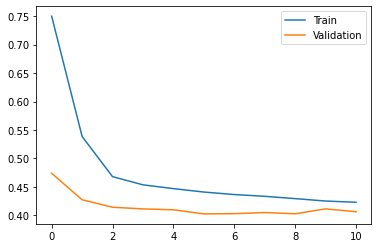

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Embedding, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization 

from matplotlib import pyplot

batch_size = 25
epochs = 20
learning_rate = 0.15
decay_rate = learning_rate / epochs
momentum = 0.9


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode = "auto")

"""model = Sequential()
model.add(LSTM(200,stateful=True,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(LSTM(200,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(layers.Dense(80, activation='relu'))
model.add(Dense(1,activation='tanh'))"""


model = Sequential()
model.add(Bidirectional(LSTM(300, return_sequences=True,input_shape=(train_X.shape[1],train_X.shape[2]))))
               #input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(200, return_sequences=True)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(200,return_sequences=True))  # return a single vector of dimension 32
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dense(120, activation = "relu"))
model.add(Dropout(0.1))
#model.add(BatchNormalization())
model.add(Dense(1))
    
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                            decay=decay_rate),loss='mean_absolute_error')

"""model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(clipnorm=1,
                        learning_rate=learning_rate, decay=decay_rate))"""
history  =model.fit(train_X, y_train, batch_size=batch_size, 
                    callbacks=[callback],epochs=epochs, validation_data = (test_X,y_test))


pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
pyplot.show()


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 600)           751200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 400)           1281600   
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 1, 200)            480800    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                        

In [13]:
model.save("/Users/aasimwani/Desktop/trained_model.h5")

In [9]:
predicted_y = model.predict(test_X)
predicted_y_inverse = scaling_function_y.inverse_transform(predicted_y)
actual_y = [[item[0] for item in scaling_function_y.inverse_transform(y_test)]]
predicted = [item[0] for item in predicted_y_inverse]
actual = [item for item in actual_y[0]]
print(mean_absolute_error(predicted,actual))


import plotly.express as px
tem_df = pd.DataFrame()
tem_df["Actual"] = actual
tem_df["Predicted"] = predicted
px.scatter(tem_df,x="Actual",y="Predicted")

2022-09-15 14:35:19.864743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:35:20.184473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:35:20.193965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:35:20.355611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:35:20.362606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   4/1438 [..............................] - ETA: 26s    

2022-09-15 14:35:20.438698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 14:35:20.494375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1438/1438 [==============================] - 15s 9ms/step
0.18628657433369952


In [10]:
print(mean_absolute_percentage_error(predicted,actual))

0.12873162021823648


In [ ]:
"""import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Embedding, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = Sequential()
model.add(Bidirectional(LSTM(60,return_sequences=True,input_shape=(train_X.shape[1],train_X.shape[2]))))
model.add(Dropout(0.20))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(1))

batch_size = 28
epochs = 50
learning_rate = 0.15
decay_rate = learning_rate / epochs
momentum = 0.9
    

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(clipnorm=1,
                        learning_rate=learning_rate, decay=decay_rate), metrics=["mae"])
history  =model.fit(train_X, y_train, batch_size=batch_size, 
                    callbacks=[callback],epochs=epochs, validation_split=0.2)


pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
pyplot.show()


predicted_y = model.predict(test_X)
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
predicted_y_inverse =  Y_scale_fx.inverse_transform(predicted_y)
print("Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(predicted_y_inverse,Y_scale_fx.inverse_transform(y_test))*100,2))
"""

In [14]:
X_data.columns 

Index(['starting_SOC', 'average_temp', 'miles_driven', 'average_speed',
       'starting_alt', 'accu_ascending', 'accu_descending', 'num_peak',
       'start_time_day', 'start_time_hour', 'BATTERY_CAPACITY',
       'MANUFACTURER'],
      dtype='object')

In [209]:

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import activations, layers
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Embedding, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from tensorflow.keras.regularizers import L1L2


class Autoencoder:
    def __init__(self,
                 data,num_epochs,num_batches):
        self.input_shape = data.shape
        self.hidden_layer_size = 200
        self.percentage_drop = [0.2,0.4,0.6,0.8]
        self.dropout_probability = 0.2
        self.learning_rate = 0.2
        self.momentum = 0.92 
        self.activation = "relu"
        self.epochs = num_epochs 
        self.batch = num_batches
        self.hidden_layers_dimensions_encoder = [int(item*self.hidden_layer_size) for item in list(reversed(self.percentage_drop))]
        self.hidden_layers_dimensions_decoder = [int(item*self.hidden_layer_size) for item in self.percentage_drop]
    
    def model(self,trainX,trainY,testX,testY):
        model = Sequential()
        #INPUT
        model.add(Dense(self.hidden_layer_size,activation = self.activation,input_dim=self.input_shape[1]))
        model.add(Dropout(self.dropout_probability))
        #ENCODER
        for val in self.hidden_layers_dimensions_encoder:
            model.add(Dense(val, activation = self.activation))
        model.add(Dropout(self.dropout_probability))
        model.add(BatchNormalization())
        #DECODER
        for val in self.hidden_layers_dimensions_decoder:
            model.add(Dense(val, activation = self.activation))
        model.add(Dropout(self.dropout_probability))
        model.add(BatchNormalization())
        model.add(Dense(self.hidden_layer_size, activation = self.activation))
        #OUTPUT
        model.add(Dense(self.input_shape[1],input_dim=self.input_shape[1],activation="sigmoid"))
        
        decay_rate = self.learning_rate/self.epochs
        model.compile(optimizer=
            tf.keras.optimizers.SGD(
                                    clipnorm=1,
                                    learning_rate=self.learning_rate, 
                                    decay=decay_rate), 
                                      loss='mse')
        
        
        
        history = model.fit(trainX,trainY,
                  shuffle=False,
                  epochs = self.epochs, 
                  batch_size = self.batch,
                  callbacks=[
                  keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,mode ="min")],
                  validation_data=(testX,testY)) 
                    #validation_split=0.2)
        
        print(model.summary())
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()
        return model 

Epoch 1/25


2022-09-14 11:53:20.353884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


497/500 [============================>.] - ETA: 0s - loss: 0.6016

2022-09-14 11:53:34.385693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 16s 19ms/step - loss: 0.6010 - val_loss: 0.5965
Epoch 2/25
500/500 [==============================] - 9s 18ms/step - loss: 0.5671 - val_loss: 0.5846
Epoch 3/25
500/500 [==============================] - 8s 15ms/step - loss: 0.5621 - val_loss: 0.5825
Epoch 4/25
500/500 [==============================] - 8s 15ms/step - loss: 0.5590 - val_loss: 0.5811
Epoch 5/25
500/500 [==============================] - 7s 15ms/step - loss: 0.5567 - val_loss: 0.5799
Epoch 6/25
500/500 [==============================] - 7s 14ms/step - loss: 0.5548 - val_loss: 0.5788
Epoch 7/25
500/500 [==============================] - 7s 14ms/step - loss: 0.5533 - val_loss: 0.5778
Epoch 8/25
500/500 [==============================] - 7s 15ms/step - loss: 0.5519 - val_loss: 0.5768
Epoch 9/25
500/500 [==============================] - 8s 16ms/step - loss: 0.5506 - val_loss: 0.5760
Epoch 10/25
500/500 [==============================] - 7s 15ms/step - loss: 0.5495 - val_loss: 0.5753

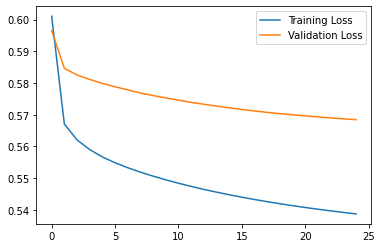

In [210]:
train_noisy = noisy_train[0:10000]
train_original = original[0:10000]

test_noisy = noisy_train[10000:20000]
test_original = original[10000:20000]

autoencoder_class = Autoencoder(data=train_noisy,num_batches=20,num_epochs=25)
model_output =  autoencoder_class.model(trainX=train_noisy, 
                                        trainY=train_original, 
                                        testX=test_noisy,
                                        testY=test_original)

In [211]:
test_noisy = pd.DataFrame(fx1.inverse_transform(model_output.predict(test_noisy)))

2022-09-14 11:56:36.259353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 6ms/step


In [212]:
test_noisy.columns = noisy_train.columns.values

In [213]:
px.histogram(test_noisy,"average_temp")